In [14]:
import os
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pydicom as di
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from PIL import Image
import threading

In [5]:
train_dir = "../dataset/train_images/"

In [6]:
#Function to get numpy array of the given image_id
def imageid_to_numpy(patient_id, image_id):
    path_to_images = train_dir + str(patient_id) + "/" + str(image_id) + ".dcm"
    dcm_image = di.dcmread(path_to_images)
    np_array = dcm_image.pixel_array
    return np_array

#Function to save dcm image as png
def save_dcm_as_png(path_to_dcm, png_save_path):
    im = Image.fromarray(imageid_to_numpy(path_to_dcm)*128)
    im.save(png_save_path)

# takes df with info of a single patient and concats the corresponding images into one
def image_concat(patient_df):

    image_array = []
    for image_id in patient_df[patient_df['laterality'] == 'L']['image_id']:
        image_array.append(imageid_to_numpy(patient_df['patient_id'][0], image_id))
    
    row1 = np.concatenate((image_array[0], image_array[1]), axis = 1) # concat L images

    for image_id in patient_df[patient_df['laterality'] == 'R']['image_id']:
        image_array.append(imageid_to_numpy(patient_df['patient_id'][0], image_id))

    row2 = np.concatenate((image_array[0], image_array[1]), axis = 1) # concat R images

    final_image = np.concatenate((row1, row2), axis=0) # concat L and R images

    # im = Image.fromarray(final_image)
    # im = im.convert('RGB')
    # im.save('./concat_images/{}.png'.format(patient_id), compress_level = 1)

    cv2.imwrite('./concat_images/{}.png'.format(patient_df['patient_id'][0]), final_image)

    #####
    # processing is very slow for some reason
    #####

In [9]:
# Loading the CSV file and cleaning the data
train_csv = pd.read_csv("../dataset/train.csv")
train_csv.head(10)

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
5,2,10011,270344397,L,MLO,55.0,0,0,0,0.0,0,NaN,21,True
6,2,10011,541722628,R,CC,55.0,0,0,0,NaN,0,NaN,21,False
7,2,10011,1031443799,R,MLO,55.0,0,0,0,NaN,0,NaN,21,False
8,2,10025,562340703,L,CC,75.0,0,0,0,NaN,0,NaN,29,False
9,2,10025,1365269360,L,MLO,75.0,0,0,0,NaN,0,NaN,29,False


In [10]:
# Creating colums for n_images -> Number of images for each patient.
#                     resolution -> Dimensions of the corresponding image.
train_csv['n_images'] = [0 for _ in range(train_csv.shape[0])]
train_csv['resolution'] = [None for _ in range(train_csv.shape[0])]
train_csv['readable'] = [None for _ in range(train_csv.shape[0])]
train_csv.head(10)

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,n_images,resolution,readable
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,0,None,None
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,0,None,None
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,0,None,None
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,0,None,None
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,0,None,None
5,2,10011,270344397,L,MLO,55.0,0,0,0,0.0,0,NaN,21,True,0,None,None
6,2,10011,541722628,R,CC,55.0,0,0,0,NaN,0,NaN,21,False,0,None,None
7,2,10011,1031443799,R,MLO,55.0,0,0,0,NaN,0,NaN,21,False,0,None,None
8,2,10025,562340703,L,CC,75.0,0,0,0,NaN,0,NaN,29,False,0,None,None
9,2,10025,1365269360,L,MLO,75.0,0,0,0,NaN,0,NaN,29,False,0,None,None


In [11]:
# Looking for Null values.
train_csv.drop(['n_images', 'resolution'], axis=1).isnull().sum()

site_id                        0
patient_id                     0
image_id                       0
laterality                     0
view                           0
age                           37
cancer                         0
biopsy                         0
invasive                       0
BIRADS                     28420
implant                        0
density                    25236
machine_id                     0
difficult_negative_case        0
readable                   54706
dtype: int64

In [28]:
def label_data(train_csv):
    for patient in tqdm(train_csv['patient_id'].unique()):
        n_images = 0
        for image in os.listdir(train_dir + str(patient)):
            n_images += 1
            try:
                current_image = imageid_to_numpy(patient, image[:-4])
                train_csv.loc[train_csv['image_id'] == int(image[:-4]), "readable"] = True
                train_csv.loc[train_csv['image_id'] == int(image[:-4]), 'resolution'] = f"{current_image.shape[0]} {current_image.shape[1]}"
            except NotImplementedError:
                train_csv.loc[train_csv['image_id'] == int(image[:-4]), "readable"] = False
        
    train_csv.loc[train_csv['patient_id'] == int(patient), 'n_images'] = n_images

    return train_csv 

In [111]:
import concurrent.futures

n_threads = 32

thread_array = [None] * n_threads

len_data = len(train_csv['patient_id'].unique()) -1

thread_workload = len_data // n_threads

partitioned_dataset = [train_csv[i * thread_workload: (i+1) * thread_workload] for i in range(n_threads)]
remainder_dataset = train_csv[:-len_data%n_threads]

threads = []

for i in range(n_threads):
    x = threading.Thread(target=label_data, args=(partitioned_dataset[i],))
    x.start()
    threads.append(x)

for thread in threads:
    thread.join()

print("Done!")

Exception in thread Thread-86:
Traceback (most recent call last):
  File "/home/lepton/miniconda3/envs/breast_cancer/lib/python3.8/site-packages/pandas/core/indexes/base.py", line 3802, in get_loc
Exception in thread Thread-85:
Traceback (most recent call last):
  File "/home/lepton/miniconda3/envs/breast_cancer/lib/python3.8/site-packages/pandas/core/indexes/base.py", line 3802, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 165, in pandas._libs.index.IndexEngine.get_loc
Exception in thread Thread-90:
Traceback (most recent call last):
  File "/home/lepton/miniconda3/envs/breast_cancer/lib/python3.8/site-packages/pandas/core/indexes/base.py", line 3802, in get_loc
Exception in thread Thread-89:
Traceback (most recent call last):


hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
Done!


In [12]:
train_csv.to_csv("./processed_train.csv")

In [8]:
#Exploring data
print(f"<-- Difficult negative case --> \n {train_csv['difficult_negative_case'].value_counts()}\n")

print(f"<-- Cancer --> \n {train_csv['cancer'].value_counts()}\n")

# The data is very skewed.

<-- Difficult negative case --> 
 False    47001
True      7705
Name: difficult_negative_case, dtype: int64

<-- Cancer --> 
 0    53548
1     1158
Name: cancer, dtype: int64



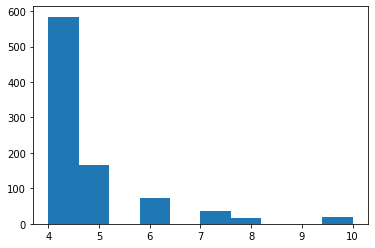

In [53]:
plt.hist(train_csv['n_images'])
plt.show()

In [13]:
train_csv['patient_id'].unique()

array([10006, 10011, 10025, ...,   997,  9973,  9989])

In [18]:
train_csv.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,n_images,resolution,readable
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,0,None,None
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,0,None,None
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,0,None,None
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,0,None,None
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,0,None,None
